# Import Packages

In [1]:
import matplotlib.pyplot as plt
from utils import create_dataset,model_plot,history_plot, read_data, plot_data, prepare_train_test_data
import numpy as np
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae

In [2]:
clean_df, data = read_data('../../datasets/yt_subscribers.csv', debug=True)

         Date  Subscribers  Unnamed: 2  Unnamed: 3  Unnamed: 4
0   8/26/2024           40         NaN         NaN         NaN
1  10/13/2024           39         NaN         NaN         NaN
2   3/28/2024           38         NaN         NaN         NaN
3   8/25/2024           38         NaN         NaN         NaN
4   7/18/2024           37         NaN         NaN         NaN
5   9/16/2024           36         NaN         NaN         NaN
6   8/10/2024           34         NaN         NaN         NaN
7   7/26/2024           33         NaN         NaN         NaN
8    9/1/2024           33         NaN         NaN         NaN
9   11/4/2024           33         NaN         NaN         NaN
----------------------------------------------------
          Date  Subscribers
254 2023-11-15           13
336 2023-11-16            8
349 2023-11-17            6
301 2023-11-18           10
215 2023-11-19           15
180 2023-11-20           17
361 2023-11-21            3
337 2023-11-22            8
35

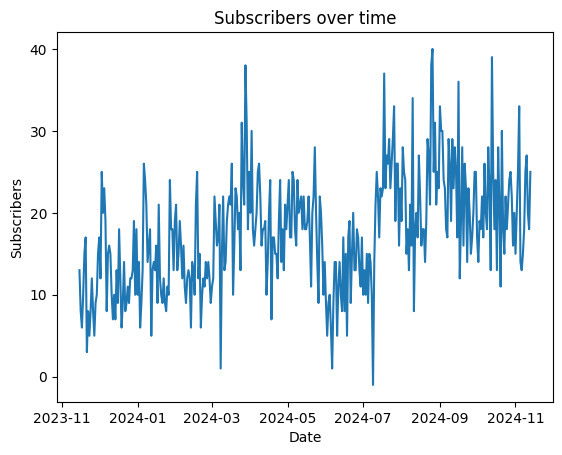

In [3]:
plot_data(clean_df["Subscribers"], title="Subscribers over time", x_label="Date", y_label="Subscribers")

In [4]:
x_train, x_test, y_train, y_test, scaler = prepare_train_test_data(data, time_step_in=7, time_step_out=7, test_size=0.2)

x_train shape: (280, 7), y_train shape: (280, 7), x_test shape: (71, 7), y_test shape: (71, 7)


In [5]:
model_1=Sequential()
model_1.add(Dense(256,input_shape=(7,),activation="relu"))
model_1.add(Dense(128,activation="relu"))
model_1.add(Dense(64,activation="relu"))
model_1.add(Dense(32,activation="relu"))
model_1.add(Dense(7))
model_1.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,511 (177.78 KB)

 Trainable params: 45,511 (177.78 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history=model_1.fit(
    x_train,y_train,
    epochs=100,
    validation_data=(x_test,y_test),
    verbose=1
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4042 - mean_absolute_error: 0.4042 - val_loss: 0.2278 - val_mean_absolute_error: 0.2278
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2053 - mean_absolute_error: 0.2053 - val_loss: 0.1106 - val_mean_absolute_error: 0.1106
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1192 - mean_absolute_error: 0.1192 - val_loss: 0.1101 - val_mean_absolute_error: 0.1101
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1239 - mean_absolute_error: 0.1239 - val_loss: 0.1196 - val_mean_absolute_error: 0.1196
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1193 - mean_absolute_error: 0.1193 - val_loss: 0.1049 - val_mean_absolute_error: 0.1049
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1179 - mean_absolute_error: 0.1179 - val_loss: 0.1038 - val_mean_absolute_error: 0.1038
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1110 - mean_absolute_error: 0.1110 - val_loss: 0.1050 - va

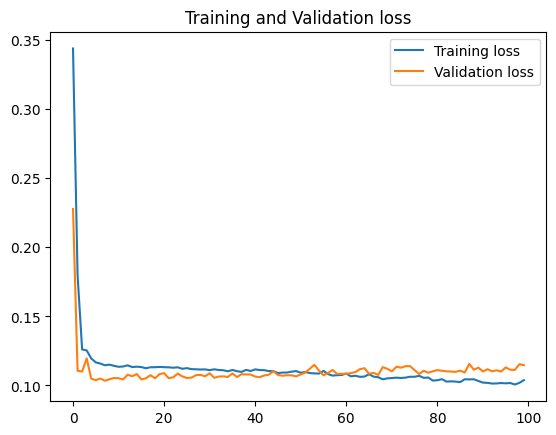

In [7]:
history_plot(history)

In [8]:
train_predicted = model_1.predict(x_train)
test_predicted = model_1.predict(x_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [9]:
# calculate MAE
mae_error_train= mae(y_train,train_predicted)
mae_error_test= mae(y_test,test_predicted)
print(f"MAE Train data  : {mae_error_train} ")
print(f"MAE  Test data : {mae_error_test} ")

MAE Train data  : 0.10354145827089874 
MAE  Test data : 0.11460501182788352 


In [10]:
all_predictions = []
input_window = x_test[-1]  

for i in range(1, 6): 
    print(f'Step {i} ==> Input Window: {input_window}')
    
    y_temp = model_1.predict(input_window.reshape(1, -1))
    print(f"Prediction Output (y_temp): {y_temp}")
    all_predictions.extend(y_temp[0])  # Add all predicted values from y_temp to the list
    input_window = np.roll(input_window, -1, axis=0)
    input_window[-1] = y_temp[0][0]  

Step 1 ==> Input Window: [0.31707317 0.3902439  0.17073171 0.26829268 0.31707317 0.29268293
 0.36585366]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction Output (y_temp): [[0.32922295 0.30118203 0.36642486 0.33273515 0.42012793 0.45457006
  0.329366  ]]
Step 2 ==> Input Window: [0.3902439  0.17073171 0.26829268 0.31707317 0.29268293 0.36585366
 0.32922295]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction Output (y_temp): [[0.31889588 0.33116266 0.30838948 0.36265337 0.35201395 0.33641315
  0.36130443]]
Step 3 ==> Input Window: [0.17073171 0.26829268 0.31707317 0.29268293 0.36585366 0.32922295
 0.31889588]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction Output (y_temp): [[0.3188124  0.31442988 0.34809163 0.34065187 0.37021035 0.42544165
  0.3491823 ]]
Step 4 ==> Input Window: [0.26829268 0.31707317 0.29268293 0.36585366 0.32922295 0.31889588
 0.3188124 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction Output (y_temp): [[0.33104298 0.32115278 0.36648977 0.35800207 0.40524867 0.4278272


In [11]:
all_predictions=np.array(all_predictions)

In [12]:
num_samples = len(all_predictions) // 7
all_predictions_reshaped = all_predictions.reshape(num_samples, 7)
y_next_30 = scaler.inverse_transform(all_predictions_reshaped)
y_next_30=np.round(y_next_30)
print(y_next_30)

[[12. 11. 14. 13. 16. 18. 13.]
 [12. 13. 12. 14. 13. 13. 14.]
 [12. 12. 13. 13. 14. 16. 13.]
 [13. 12. 14. 14. 16. 17. 13.]
 [13. 13. 13. 14. 15. 16. 14.]]


In [13]:
x_test=scaler.inverse_transform(x_test)
x_train=scaler.inverse_transform(x_train)

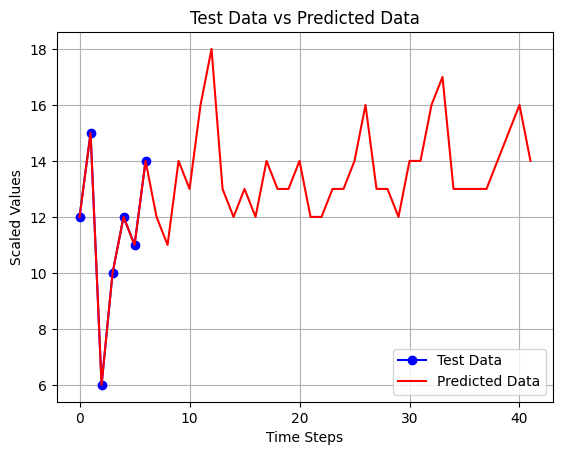

In [14]:
plt.plot(x_test[-1], label='Test Data', color='blue', marker='o')
plt.plot(np.hstack([x_test[-1], y_next_30.reshape(-1)]), label='Predicted Data', color='red')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
last_date = clean_df.index[-1]
total_sub = np.sum(np.array(clean_df['Subscribers']))
total_next_30 = np.sum(y_next_30)
print(f"Total subscribers till {last_date}: {total_sub}, next_30_days: {np.round(total_next_30)} => final after 30 days: {total_sub + round(total_next_30)}")

Total subscribers till 2024-11-13 00:00:00: 6383, next_30_days: 478.0 => final after 30 days: 6861


In [16]:
avg_sub = np.mean(np.array(clean_df['Subscribers']))
avg_sub * 30

524.6301369863014